In [69]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import precision_score, precision_recall_curve, recall_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

**TAKEAWAYS**
- Dataset is filtered and processed as required: only orders with 5 or more products are selected, and a temporal splitting of train and test sets is chosen to prevent information leakage.
- Different models tested against a baseline. The baseline chosen is the variable 'global popularity'. The metrics are ROC AUC and precision-recall AUC, since they work well on unbalanced targets.
- The models used are logistic regression, random forest and gradient boosting classifier. They are tuned and their performance is tested in a validation set. 
- In some cases the training set is reduced to speed up a bit the training time, with no significant downgrade in the results.
- All of the models outperform the chosen baseline, but some of them are better than others.
- Gradient boosting classifier comes out as the best performing model, followed by logistic regression.

In [70]:
df = pd.read_csv('/home/alvaro/groceries/boxbuilder.csv')

In [71]:
# transform datetime columns
df.created_at = pd.to_datetime(df.created_at)
df.order_date = pd.to_datetime(df.order_date,format='%Y-%m-%d %H:%M:%S')
# filter to only keep orders with more than 5 bought products
ids = df[df.outcome == 1].groupby('order_id').variant_id.count() > 4
df2 = df[df.order_id.isin(ids[ids == True].index)]

DATA SPLITTING

In [72]:
# prevent info leakage by separating train, validation and test sets by time
df3 = df2.sort_values(by='order_date')

grouped_by_order = df3.groupby('order_id')
train_cutoff = grouped_by_order.order_date.unique().head(int(len(grouped_by_order)*0.6)).iloc[-1][0]
val_cutoff = grouped_by_order.order_date.unique().head(int(len(grouped_by_order)*0.8)).iloc[-1][0]
print('Train cutoff date: ',train_cutoff)
print('Validation cutoff date: ',val_cutoff)

Train cutoff date:  2021-01-26 00:00:00
Validation cutoff date:  2021-02-15 00:00:00


In [73]:
df_train = df3[df3.order_date <= train_cutoff]
df_val = df3.loc[(df3.order_date > train_cutoff) & (df3.order_date <= val_cutoff)]
df_test = df3[df3.order_date > val_cutoff]

X_train, y_train = (df_train.drop(['outcome'], axis=1), df_train.outcome) 
X_val, y_val = (df_val.drop(['outcome'], axis=1), df_val.outcome) 
X_test, y_test = (df_test.drop(['outcome'], axis=1), df_test.outcome) 

In [74]:
columns = [
    'user_order_seq', 
    'ordered_before',
    'abandoned_before', 
    'active_snoozed', 
    'set_as_regular',
    'normalised_price', 
    'discount_pct', 
    'global_popularity',
    'count_adults', 
    'count_children', 
    'count_babies', 
    'count_pets',
    'people_ex_baby', 
    'days_since_purchase_variant_id',
    'avg_days_to_buy_variant_id', 
    'std_days_to_buy_variant_id',
    'days_since_purchase_product_type', 
    'avg_days_to_buy_product_type',
    'std_days_to_buy_product_type'
    ]

In [75]:
def plot_curves(model: str, y_pred: pd.Series, y: pd.Series, figure: tuple):

    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    prec, rec, thresholds = precision_recall_curve(y, y_pred)
    pr_auc = auc(rec, prec)

    fig, axs = figure
    axs[0].plot(fpr, tpr, label= f'{model}, AUC = %.2f' % roc_auc)
    axs[1].plot(rec, prec, label= f'{model}, AUC = %.2f' % pr_auc)

    axs[0].set_title('ROC curve')
    axs[0].set_xlabel('False positive rate')
    axs[0].set_ylabel('True positive rate')
    axs[0].legend(loc="lower right")

    axs[1].set_title('Precision-recall curve')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend(loc="upper right")


BASELINE

The variable 'global popularity' is chosen as a baseline to test the performance of the models. Since the target is sparse, precision-recall curve and its AUC is used as a metric apart from ROC curve.

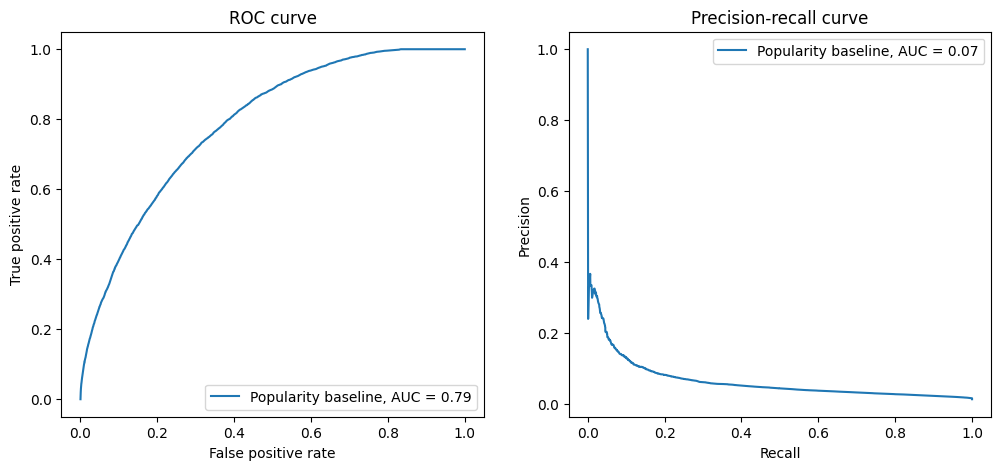

In [76]:
y_pred = df_val['global_popularity']
y_test = df_val['outcome']

figure = plt.subplots(1,2, figsize=(12, 5))

plot_curves('Popularity baseline', y_pred, y_test, figure)


LOGISTIC REGRESSION

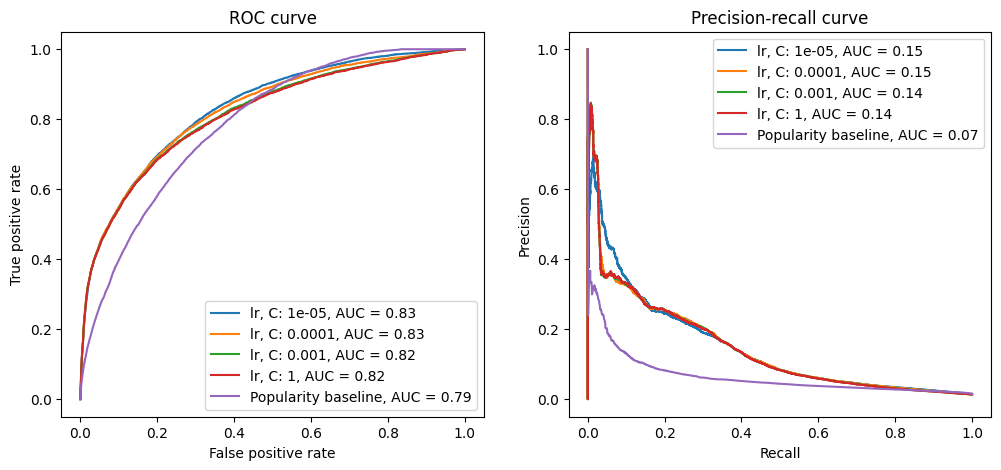

In [77]:
figure = plt.subplots(1,2, figsize=(12, 5))

Cs = [0.00001, 0.0001, 0.001,1]

for C in Cs:
    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=C)
    )
    lr.fit(X_train[columns], y_train)
    
    val_proba = lr.predict_proba(X_val[columns])[:, 1]
    plot_curves(f'lr, C: {C}', val_proba, y_val, figure)

plot_curves('Popularity baseline', y_pred, y_test, figure)


Logistic regression performs better than the baseline. As seen before, in this problem regularisation does not have a big influence in the results for logistic regression. Now it is time to try some non linear models, where logistic regression can be used as a baseline.

RANDOM FOREST

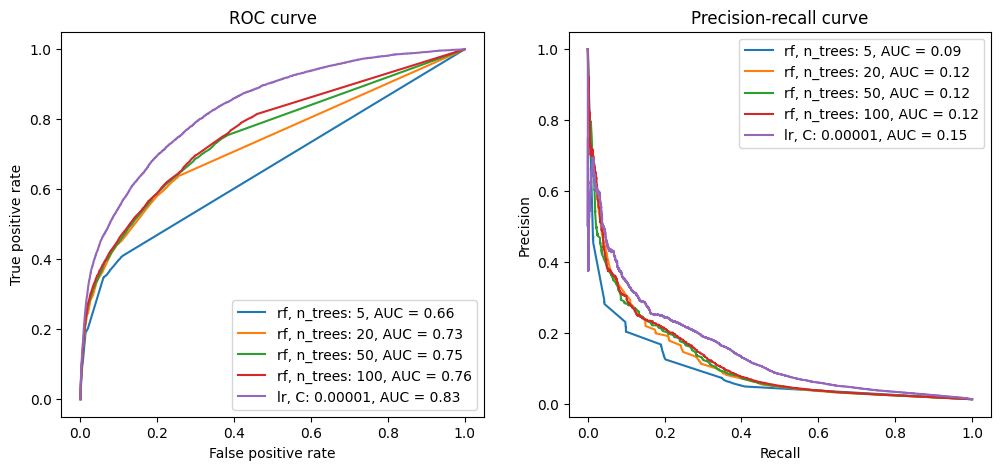

In [78]:
figure = plt.subplots(1,2, figsize=(12, 5))

n_trees = [5, 20, 50, 100]

for trees in n_trees:
    rf = RandomForestClassifier(trees)
    rf.fit(X_train[columns].head(int(len(X_train)*0.2)), y_train.head(int(len(X_train)*0.2)))
    
    val_proba = rf.predict_proba(X_val[columns])[:, 1]
    plot_curves(f'rf, n_trees: {trees}', val_proba, y_val, figure)

lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=0.00001)
)
lr.fit(X_train[columns], y_train)

val_proba = lr.predict_proba(X_val[columns])[:, 1]
plot_curves('lr, C: 0.00001', val_proba, y_val, figure)

The baseline is better than the new model. Perhaps the score would improve if unnecessary variables were removed, as the trees of the model would have better quality.

In [79]:
# top 15 most important features
indices = np.argsort(rf.feature_importances_)[::-1]
print(indices)
top_features = X_train[columns].columns[indices[:15]].to_list()
top_features


[ 7  0  2  1 16 15 14  6  5 18 17 11 13 12  3  9  8  4 10]


['global_popularity',
 'user_order_seq',
 'abandoned_before',
 'ordered_before',
 'days_since_purchase_product_type',
 'std_days_to_buy_variant_id',
 'avg_days_to_buy_variant_id',
 'discount_pct',
 'normalised_price',
 'std_days_to_buy_product_type',
 'avg_days_to_buy_product_type',
 'count_pets',
 'days_since_purchase_variant_id',
 'people_ex_baby',
 'active_snoozed']

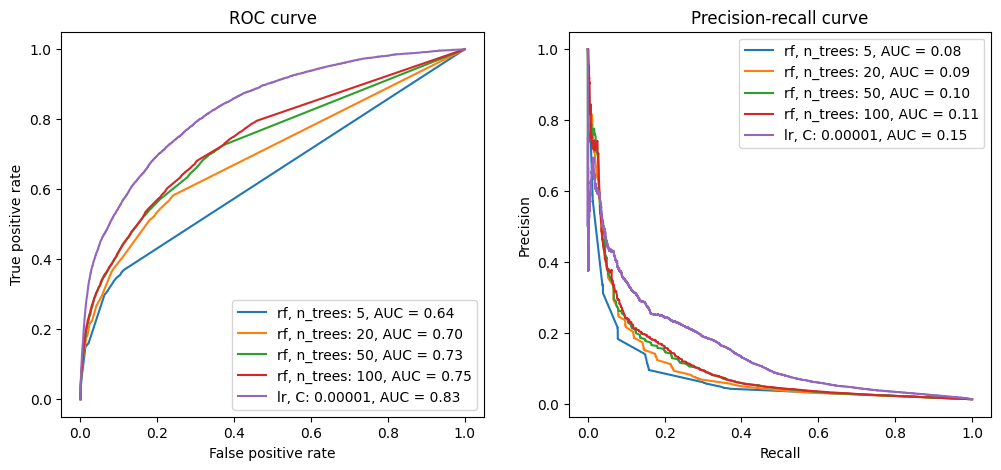

In [80]:
figure = plt.subplots(1,2, figsize=(12, 5))

n_trees = [5, 20, 50, 100]

for trees in n_trees:
    rf = RandomForestClassifier(trees)
    rf.fit(X_train[top_features].head(int(len(X_train)*0.2)), y_train.head(int(len(X_train)*0.2)))
    
    val_proba = rf.predict_proba(X_val[top_features])[:, 1]
    plot_curves(f'rf, n_trees: {trees}', val_proba, y_val, figure)

lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=0.00001)
)
lr.fit(X_train[columns], y_train)

val_proba = lr.predict_proba(X_val[columns])[:, 1]
plot_curves('lr, C: 0.00001', val_proba, y_val, figure)

The model performance is roughly the same, which means the removed variables had little importance.

GRADIENT BOOSTING CLASSIFIER

In [81]:
n_trees = [5, 20, 50, 100]
depths = [1, 3, 5]

for rate in [0.05, 0.1]:
    for depth in depths:
        for trees in n_trees:
            gbt = GradientBoostingClassifier(n_estimators=trees, max_depth=depth, learning_rate=rate)
            gbt.fit(X_train[columns].head(int(len(X_train)*0.2)), y_train.head(int(len(X_train)*0.2)))
            
            val_proba = gbt.predict_proba(X_val[columns])[:, 1]

            fpr, tpr, thresholds = roc_curve(y_val, val_proba)
            roc_auc = auc(fpr, tpr)
            prec, rec, thresholds = precision_recall_curve(y_val, val_proba)
            pr_auc = auc(rec, prec)
            print(f'gbt, n_trees: {trees}, max depth: {depth}, learning rate: {rate}\n',
                    f'ROC AUC: {roc_auc}, PR AUC: {pr_auc}')

lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=0.00001)
)
lr.fit(X_train[columns], y_train)

val_proba = lr.predict_proba(X_val[columns])[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, val_proba)
roc_auc = auc(fpr, tpr)
prec, rec, thresholds = precision_recall_curve(y_val, val_proba)
pr_auc = auc(rec, prec)
print('Linear regression\n',
        f'ROC AUC: {roc_auc}, PR AUC: {pr_auc}')

gbt, n_trees: 5, max depth: 1, learning rate: 0.05
 ROC AUC: 0.6456418727352878, PR AUC: 0.1842387499141326
gbt, n_trees: 20, max depth: 1, learning rate: 0.05
 ROC AUC: 0.7268986932133276, PR AUC: 0.1516868917194653
gbt, n_trees: 50, max depth: 1, learning rate: 0.05
 ROC AUC: 0.7983142022529766, PR AUC: 0.14498012342615463


gbt, n_trees: 100, max depth: 1, learning rate: 0.05
 ROC AUC: 0.8180675334700194, PR AUC: 0.1455604721018768
gbt, n_trees: 5, max depth: 3, learning rate: 0.05
 ROC AUC: 0.761948315044448, PR AUC: 0.15608472286494235
gbt, n_trees: 20, max depth: 3, learning rate: 0.05
 ROC AUC: 0.8106322625011054, PR AUC: 0.15953303077515546
gbt, n_trees: 50, max depth: 3, learning rate: 0.05
 ROC AUC: 0.8361125825905695, PR AUC: 0.1605863233245718
gbt, n_trees: 100, max depth: 3, learning rate: 0.05
 ROC AUC: 0.8374910972752334, PR AUC: 0.1480404995845002
gbt, n_trees: 5, max depth: 5, learning rate: 0.05
 ROC AUC: 0.8269799830630999, PR AUC: 0.13732800376109502
gbt, n_trees: 20, max depth: 5, learning rate: 0.05
 ROC AUC: 0.8327207990782883, PR AUC: 0.14214322871697815
gbt, n_trees: 50, max depth: 5, learning rate: 0.05
 ROC AUC: 0.8378144784577811, PR AUC: 0.14514019710697093
gbt, n_trees: 100, max depth: 5, learning rate: 0.05
 ROC AUC: 0.8384790814572953, PR AUC: 0.14215107232590585
gbt, n_trees:

The hyperparameters n_trees: 50, max depth: 3, learning rate: 0.05 give the best scores, slightly outperforming linear regression.


COMPARING ALL THE MODELS

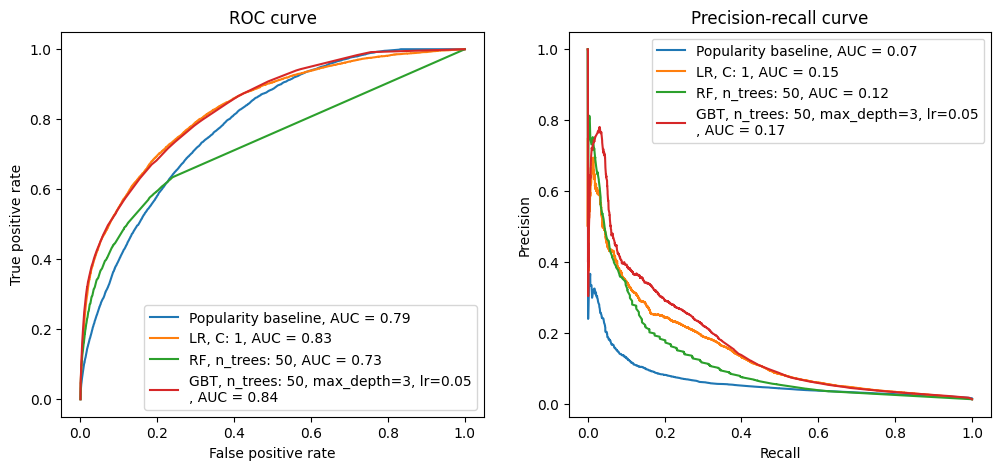

In [82]:
figure = plt.subplots(1,2, figsize=(12, 5))

# Baseline
y_pred = df_val['global_popularity']
y_test = df_val['outcome']
plot_curves('Popularity baseline', y_pred, y_test, figure)

# Logistic regression
lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=0.00001)
)
lr.fit(X_train[columns], y_train)
val_proba = lr.predict_proba(X_val[columns])[:, 1]
plot_curves(f'LR, C: {C}', val_proba, y_val, figure)

# Random forest
rf = RandomForestClassifier(50)
rf.fit(X_train[columns], y_train)

val_proba = rf.predict_proba(X_val[columns])[:, 1]
plot_curves(f'RF, n_trees: 50', val_proba, y_val, figure)

# Gradient boosting classifier
gbt = GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.05)
gbt.fit(X_train[columns], y_train)

val_proba = gbt.predict_proba(X_val[columns])[:, 1]
plot_curves(f'GBT, n_trees: 50, max_depth=3, lr=0.05\n', val_proba, y_val, figure)


The gradient boosting classifier gets the best results of all the models.